In [272]:
import warnings

warnings.filterwarnings(action='ignore') 





In [273]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['font.family'].insert(0, 'Malgun Gothic')
# 주피터 노트북을 사용하는 경우에는 다음처럼 매직(magic) 명령으로 노트북 내부에 그림을 표시하도록 지정해야 한다.
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


# 목표 : 코로나 확진자 수에 따른 카드, 유통 데이터의 민감도를 행정동별로 알아보자

### 이 지표가 괜찮다면 산업별로도, 물류도 포함할 예정입니다

In [274]:
# 카드소비(국내자) 데이터
card_re = pd.read_csv("CARD_SPENDING_RESIDENT/CARD_SPENDING_RESIDENT.txt", sep ="\t")
# 카드 동별 데이터
card_dong = pd.read_csv("card_instruct.csv", encoding="CP949")
# 일자별로 정리되어 있는 데이터
date_table = pd.read_csv("date_table.csv")

- 코로나 데이터 : 일단 찾아서 직접 입력함(누적 확진자수)

In [275]:
corona = [0, 29, 433, 3736, 6284, 7979, 8652, 9332, 10156, 10480, 10653, 10718, 10780, 10840, 11037, 11165, 11541,11852, 12155,
         12484, 12799]

In [276]:
# 이 dataframe에 채울 것
# x - 코로나에 따른 유동인구의 변화도
# y - 코로나에 따른 카드소비(AMT)의 변화도

card_gu_dong_distance = card_dong[ ["구명","행정동명"] ]

In [277]:
card_gu_dong_distance

,구명,행정동명
0,서울 중구,소공동
1,서울 중구,회현동
2,서울 중구,명동
3,서울 중구,필동
4,서울 중구,장충동
...,...,...
64,대구 중구,남산2동
65,대구 중구,남산3동
66,대구 중구,남산4동
67,대구 중구,대봉1동


In [278]:
# card소비+카드동 데이터 합치기
card = card_re.merge(card_dong, how='left', left_on = ['GU_CD', 'DONG_CD'], right_on = ['구코드','행정동코드'])

In [279]:
# card소비+일자별 데이터 합치기
card = card.merge(date_table, how='left',on='STD_DD')

In [280]:
card.drop(['STD_DD','구코드','행정동코드'], axis=1, inplace=True)

In [281]:
# 구, 행정동, year, month, week별 총매출액과 매출건수
card_amt_cnt = card.pivot_table(index=['구명','행정동명','year','month','week_num'], values=['USE_AMT','USE_CNT'], aggfunc='sum')

In [282]:
card_amt_cnt

USE_AMT  USE_CNT
구명     행정동명 year month week_num                   
대구 수성구 고산1동 2019 2     4           862560    33193
                       5          2104217    93235
                       6          2080807    88428
                       7          2276446    90801
                       8          1639456    67127
...                                   ...      ...
서울 중구  회현동  2020 5     18        19954783   426150
                       19        19037551   426979
                       20        20662444   467128
                       21        20728879   483064
                       22         2891226    46672

[2898 rows x 2 columns]

In [283]:
# dong별로 카드소비 변화도를 볼 수 있는 함수
def dong_diff(dong):
    card_temp = card_amt_cnt.reset_index()
    card_daegu_suseonggu_gosan1 = card_temp[card_temp['행정동명'] == dong]
    card_daegu_suseonggu_gosan1_2020 = card_daegu_suseonggu_gosan1[card_daegu_suseonggu_gosan1['year'] == 2020]
    card_daegu_suseonggu_gosan1_2020_diff = card_daegu_suseonggu_gosan1_2020['USE_AMT'].diff()
    card_temp = card_daegu_suseonggu_gosan1_2020[ ['구명','행정동명'] ]
    card_temp = card_temp.reset_index()
    temp = pd.DataFrame(card_daegu_suseonggu_gosan1_2020_diff)
    temp = temp.reset_index()
    card_temp2 = card_temp.merge(temp, how='left', on='index')
    card_temp2.plot()
    plt.title(dong)

    

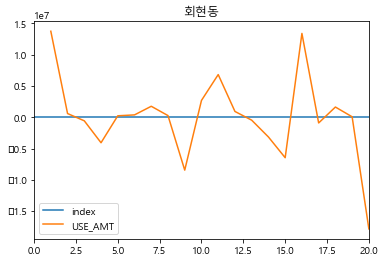

In [352]:
dong_diff("회현동")

## 코로나에 대한 카드소비 변화량의 민감도

In [284]:
# 코로나에 대한 카드소비데이터 변화량의 민감도
tmp_df = pd.DataFrame()
fig = plt.figure(figsize=(18, 30))
dong_list = card['행정동명'].unique()

card_distance = []
for idx, line in enumerate(dong_list):
    
    card_temp = card_amt_cnt.reset_index()
    card_daegu_suseonggu_gosan1 = card_temp[card_temp['행정동명'] == line]
    card_daegu_suseonggu_gosan1_2020 = card_daegu_suseonggu_gosan1[card_daegu_suseonggu_gosan1['year'] == 2020]
    card_daegu_suseonggu_gosan1_2020_diff = card_daegu_suseonggu_gosan1_2020['USE_AMT'].diff()
    card_temp = card_daegu_suseonggu_gosan1_2020[ ['구명','행정동명'] ]
    card_temp = card_temp.reset_index()
    temp = pd.DataFrame(card_daegu_suseonggu_gosan1_2020_diff)
    temp = temp.reset_index()
    card_temp2 = card_temp.merge(temp, how='left', on='index')
    
    temp = pd.DataFrame(card_daegu_suseonggu_gosan1_2020_diff)
    temp = temp.reset_index()
    card_temp2 = card_temp.merge(temp, how='left', on='index')
    
    card_temp2['코로나누적'] = corona
    card_temp2['코로나주차'] = card_temp2['코로나누적'].diff()
    card_temp2['코로나차이'] = card_temp2['코로나주차'].diff()
    
    card_temp2["AMT"] = card_daegu_suseonggu_gosan1_2020['USE_AMT']
    temp0 = pd.DataFrame(card_daegu_suseonggu_gosan1_2020['USE_AMT']).reset_index()
    card_temp2 = card_temp2.merge(temp0, how='left', on='index')
    card_temp2.drop("AMT",axis=1,inplace=True)
    
    # 여기가 핵심, 그래프의 유사도를 파악할 때 오차(차이) 제곱이 맞는 것 같은데, 너무 크게 나와서 일단 나눔
    # 좋은 의견 있으면 말해주세용
    card_temp2['distance'] = card_temp2['USE_AMT_x']/card_temp2['코로나차이']
    
    card_distance.append(card_temp2['distance'].sum())

    

<Figure size 1296x2160 with 0 Axes>

In [285]:
card_gu_dong_distance["card_gu_dong_distance"] = card_distance

In [288]:
card_gu_dong_distance

,구명,행정동명,card_gu_dong_distance
0,서울 중구,소공동,55803.616579
1,서울 중구,회현동,77698.917464
2,서울 중구,명동,9146.973300
3,서울 중구,필동,46092.527832
4,서울 중구,장충동,23981.252091
...,...,...,...
64,대구 중구,남산2동,39287.764375
65,대구 중구,남산3동,126187.319727
66,대구 중구,남산4동,4433.772193
67,대구 중구,대봉1동,61630.557856


<Figure size 1296x2160 with 0 Axes>

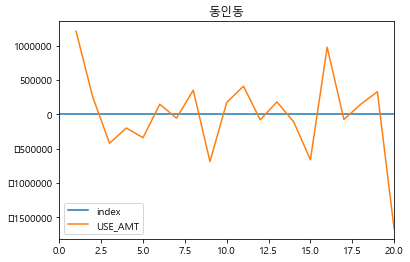

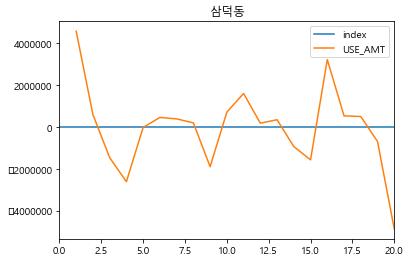

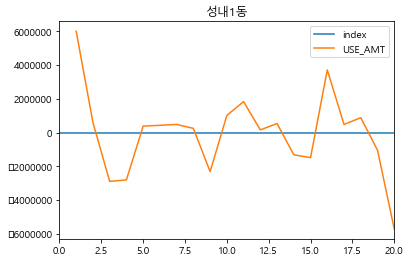

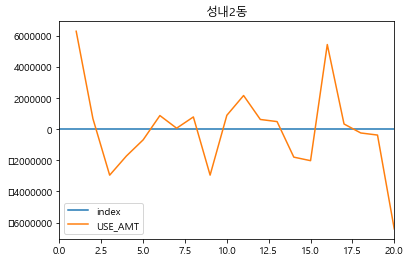

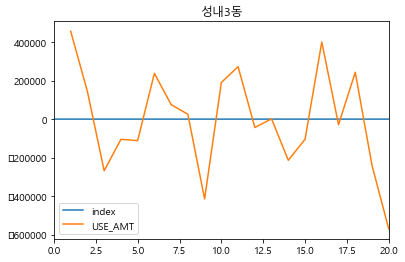

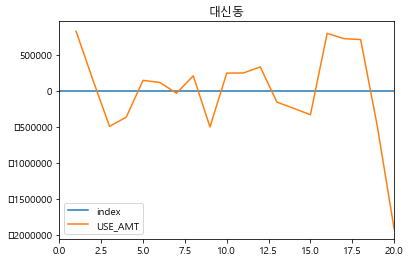

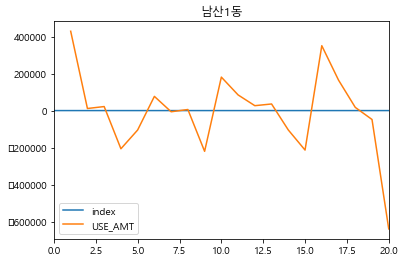

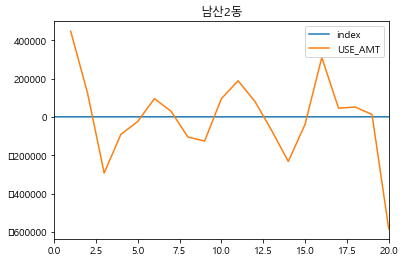

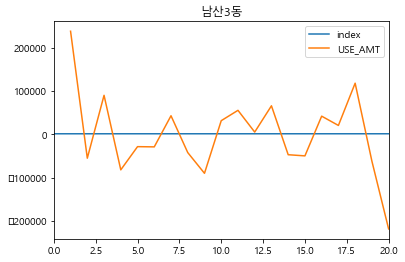

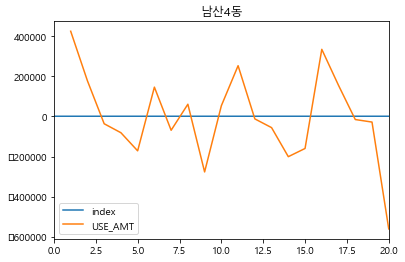

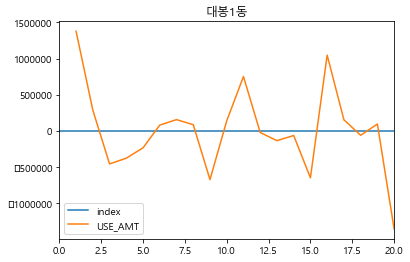

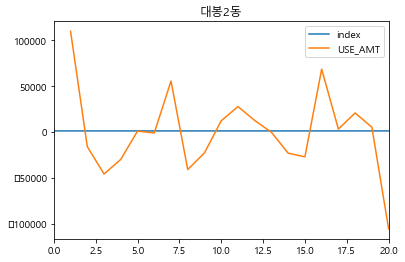

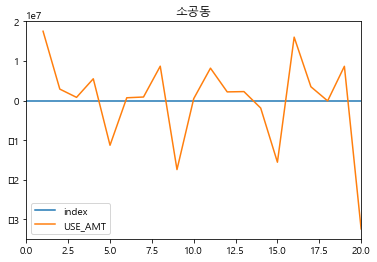

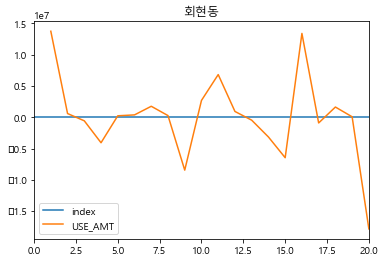

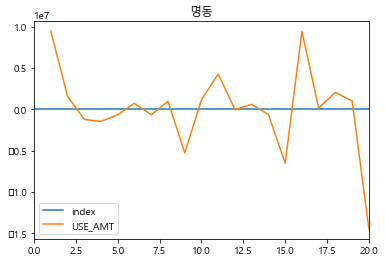

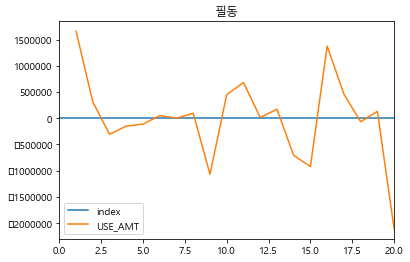

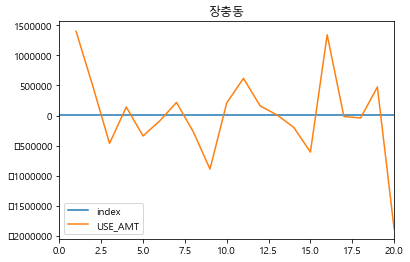

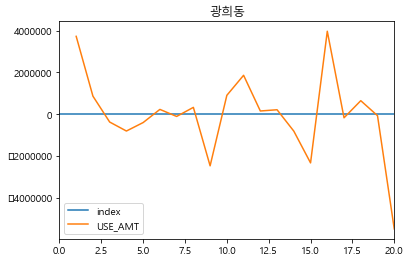

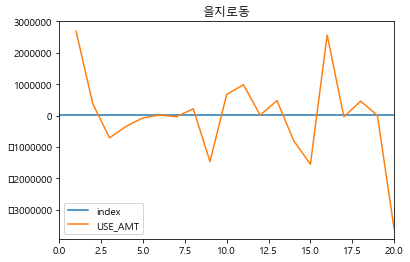

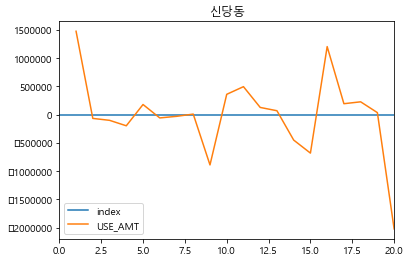

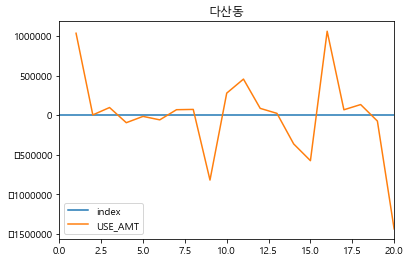

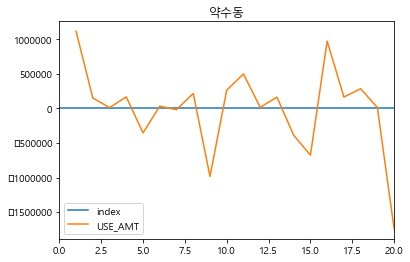

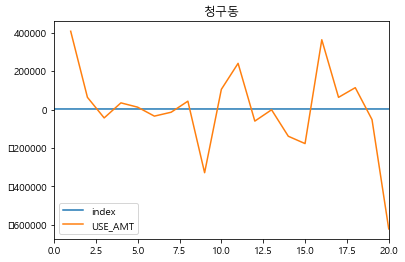

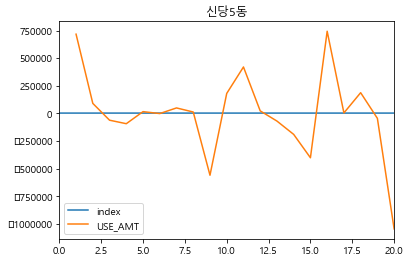

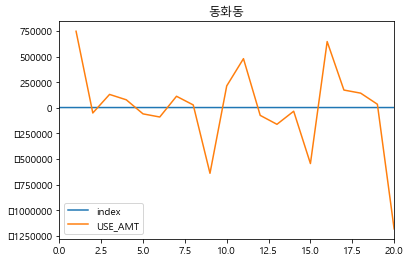

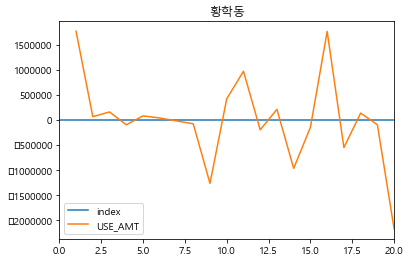

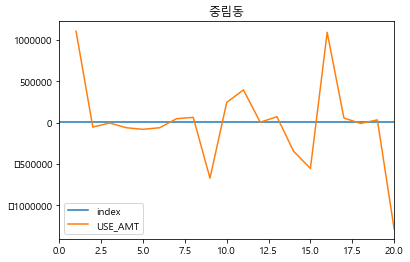

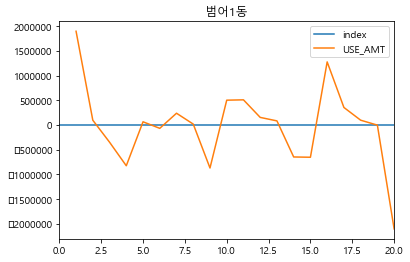

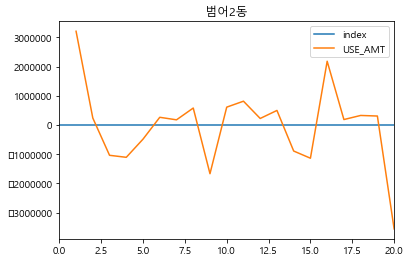

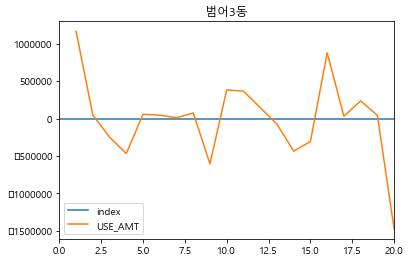

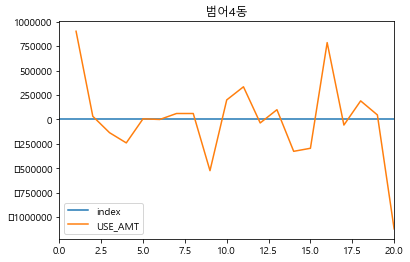

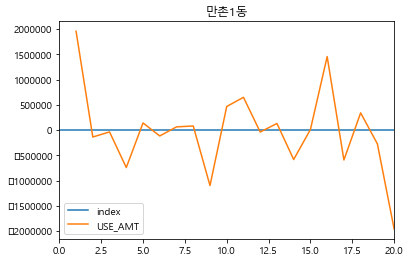

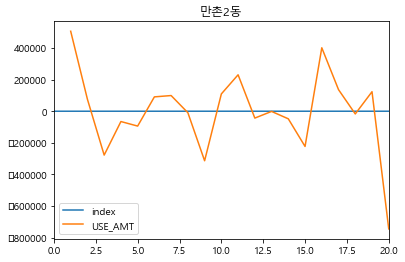

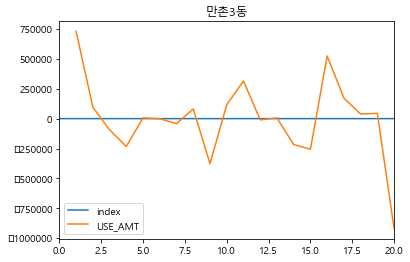

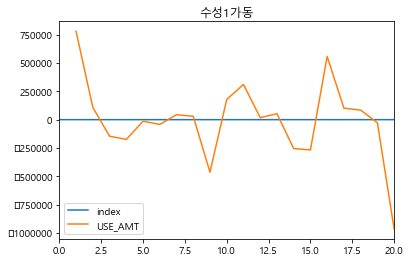

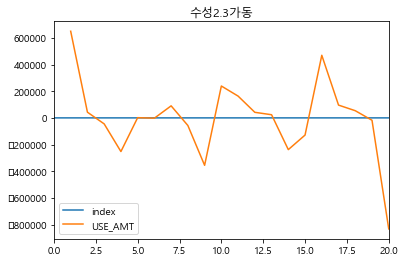

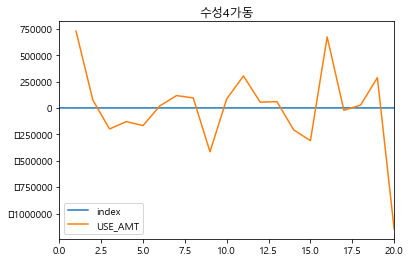

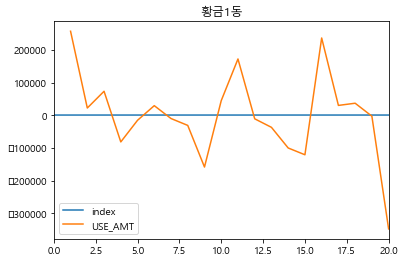

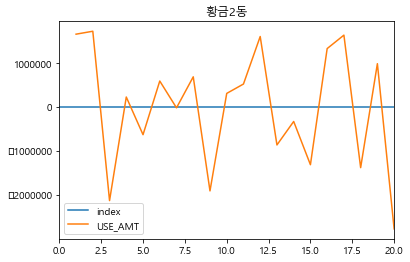

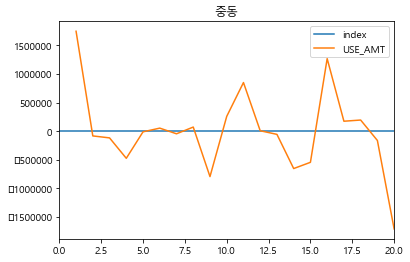

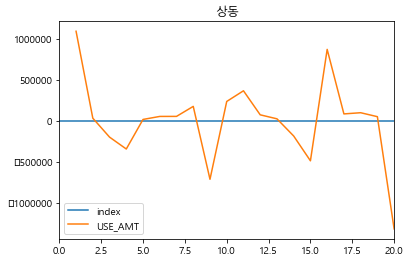

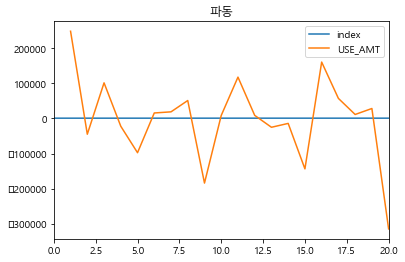

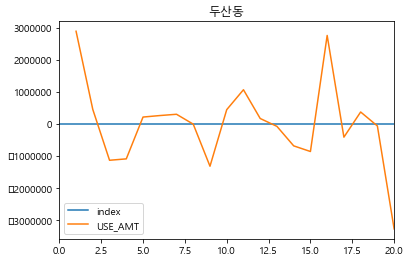

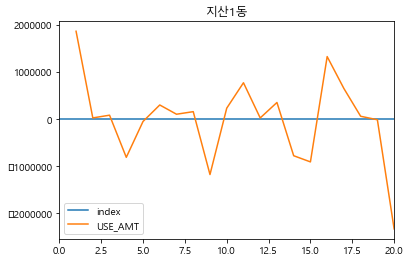

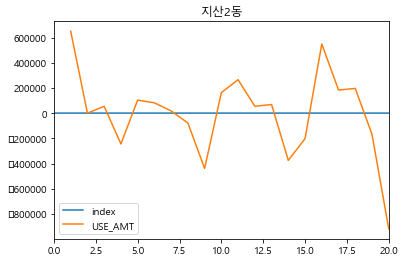

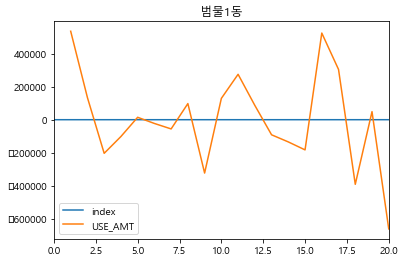

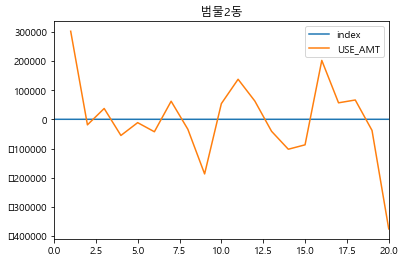

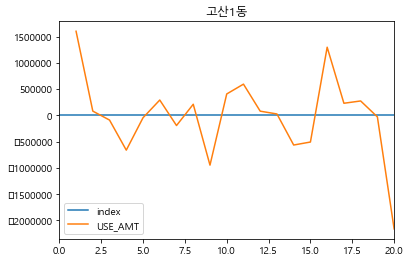

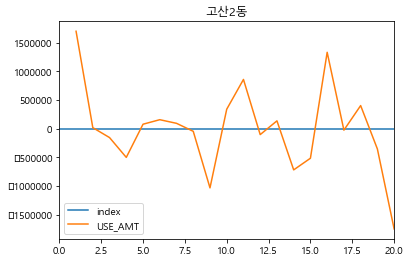

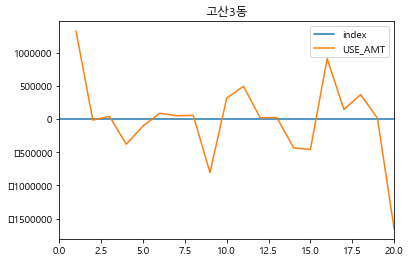

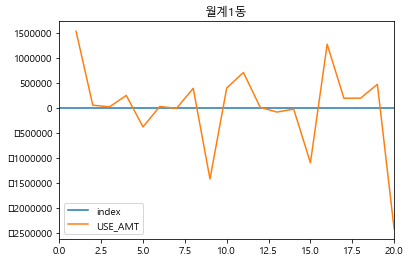

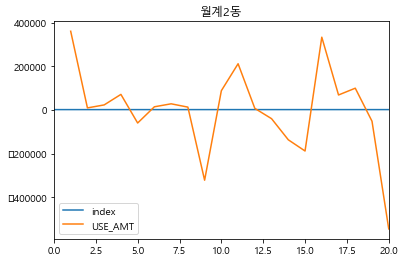

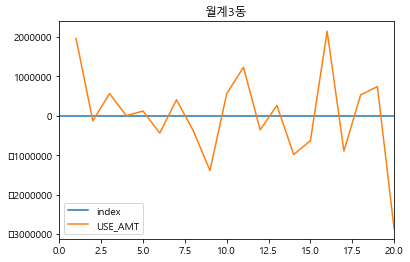

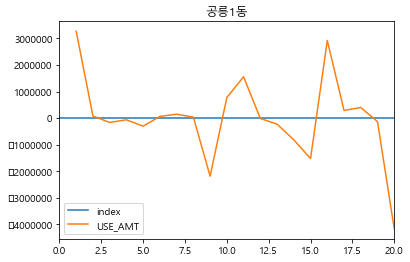

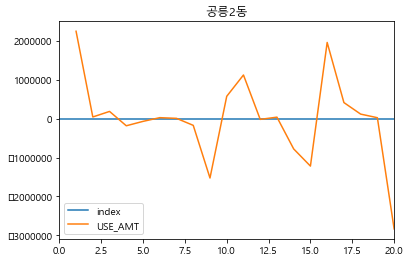

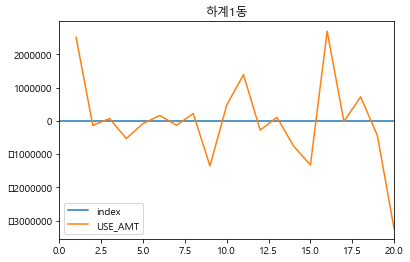

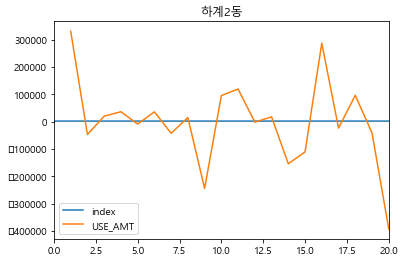

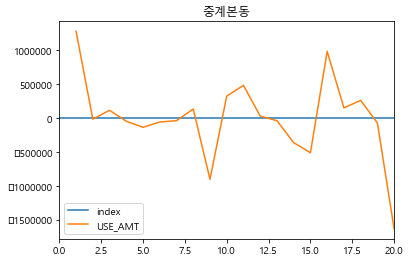

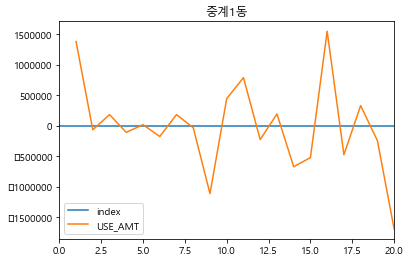

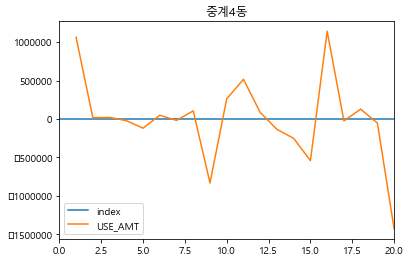

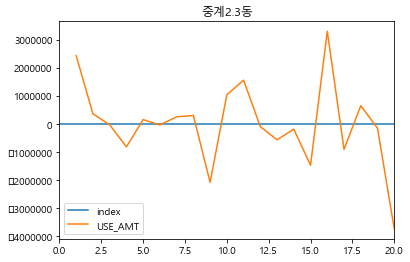

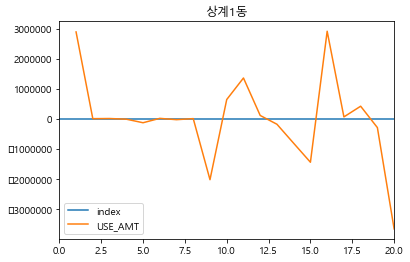

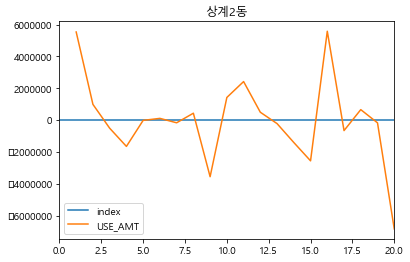

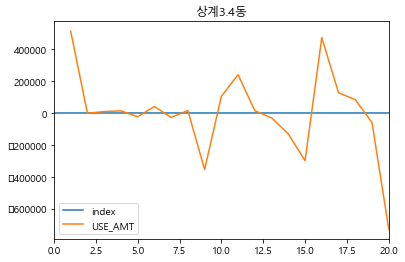

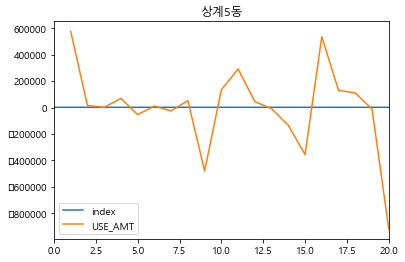

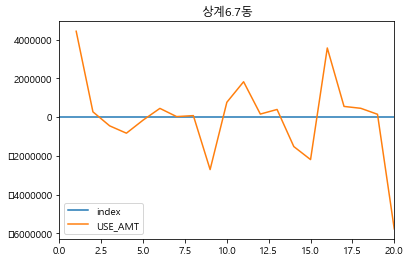

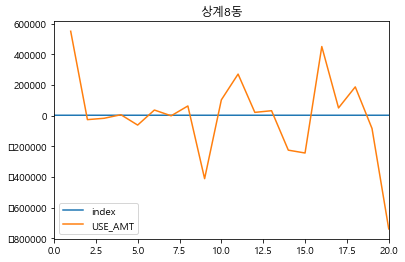

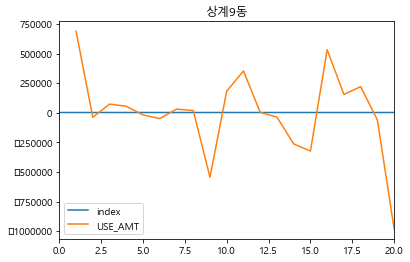

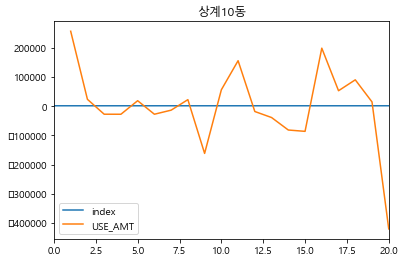

In [259]:
# 동별로 카드소비데이터 변화도를 봄
# subplot으로 이쁘게 한 번에 어떻게 찍지. 반복문 돌리면서
tmp_df = pd.DataFrame()
fig = plt.figure(figsize=(18, 30))

for idx, line in enumerate(dong_list):
    dong_diff(line)

In [224]:
# 중간 테스트 코드
temp = pd.DataFrame(card_daegu_suseonggu_gosan1_2020_diff)
temp = temp.reset_index()
card_temp2 = card_temp.merge(temp, how='left', on='index')

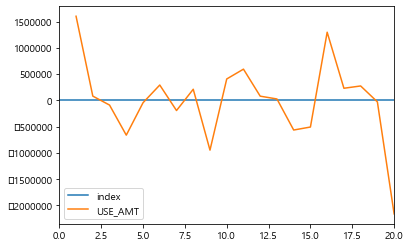

In [229]:
card_temp2.plot()

In [234]:
# 중간 테스트 코드 2
card_temp2['코로나누적'] = corona
card_temp2['코로나주차'] = card_temp2['코로나누적'].diff()
card_temp2['코로나차이'] = card_temp2['코로나주차'].diff()

In [235]:
card_temp2

,index,구명,행정동명,USE_AMT,코로나누적,코로나주차,코로나차이
0,21,대구 수성구,고산1동,NaN,0,NaN,NaN
1,22,대구 수성구,고산1동,1602921.0,29,29.0,NaN
2,23,대구 수성구,고산1동,81900.0,433,404.0,375.0
3,24,대구 수성구,고산1동,-88919.0,3736,3303.0,2899.0
4,25,대구 수성구,고산1동,-661618.0,6284,2548.0,-755.0
5,26,대구 수성구,고산1동,-44363.0,7979,1695.0,-853.0
6,27,대구 수성구,고산1동,292831.0,8652,673.0,-1022.0
7,28,대구 수성구,고산1동,-192882.0,9332,680.0,7.0
8,29,대구 수성구,고산1동,212345.0,10156,824.0,144.0
9,30,대구 수성구,고산1동,-946851.0,10480,324.0,-500.0


### 총 매출액 수의 변화그래프와 코로나 확진자수의 변화 그래프 비교

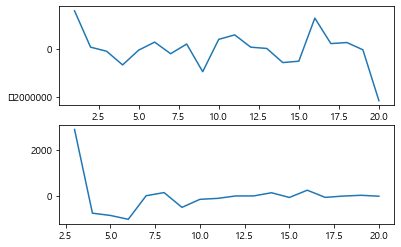

In [236]:
plt.subplot(2,1,1)
plt.plot(card_temp2['USE_AMT'])
plt.subplot(2,1,2)
plt.plot(card_temp2['코로나차이'][3:]) # null값 있는 1,2주차 제거

- 변화의 폭은 차이가 있겠지만, 그래프의 양상은 비슷하다(내려갈 때 같이 내려가고, 올라갈 때 같이 올라가고)
- 이 비슷한 그래프의 형태를 수학적으로 접근해서 객관적인 공식(지수?)을 만들고자 함

In [123]:
card_temp2

,index,구명,행정동명,USE_AMT,코로나누적,코로나주차,코로나차이
0,21,대구 수성구,고산1동,NaN,0,NaN,NaN
1,22,대구 수성구,고산1동,1602921.0,29,29.0,NaN
2,23,대구 수성구,고산1동,81900.0,433,404.0,375.0
3,24,대구 수성구,고산1동,-88919.0,3736,3303.0,2899.0
4,25,대구 수성구,고산1동,-661618.0,6284,2548.0,-755.0
5,26,대구 수성구,고산1동,-44363.0,7979,1695.0,-853.0
6,27,대구 수성구,고산1동,292831.0,8652,673.0,-1022.0
7,28,대구 수성구,고산1동,-192882.0,9332,680.0,7.0
8,29,대구 수성구,고산1동,212345.0,10156,824.0,144.0
9,30,대구 수성구,고산1동,-946851.0,10480,324.0,-500.0


### 더욱 확실하게 보고자 산점도에 추세선을 그려 비교

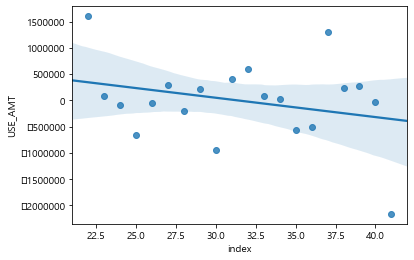

In [237]:
sns.regplot(x='index',y='USE_AMT',data=card_temp2, fit_reg=True)

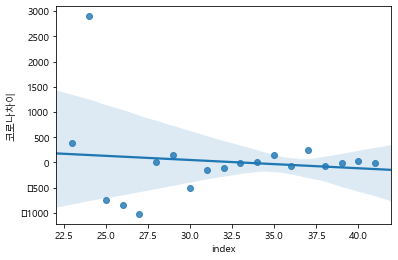

In [238]:
sns.regplot(x='index',y='코로나차이',data=card_temp2, fit_reg=True)

- 형태는 비슷하게 진행되고, 6주간의 차이가 있다.

In [239]:
card_temp2["AMT"] = card_daegu_suseonggu_gosan1_2020['USE_AMT']
temp0 = pd.DataFrame(card_daegu_suseonggu_gosan1_2020['USE_AMT']).reset_index()
card_temp2 = card_temp2.merge(temp0, how='left', on='index')
card_temp2.drop("AMT",axis=1,inplace=True)

In [244]:
card_temp2

,index,구명,행정동명,USE_AMT_x,코로나누적,코로나주차,코로나차이,USE_AMT_y
0,21,대구 수성구,고산1동,NaN,0,NaN,NaN,348924
1,22,대구 수성구,고산1동,1602921.0,29,29.0,NaN,1951845
2,23,대구 수성구,고산1동,81900.0,433,404.0,375.0,2033745
3,24,대구 수성구,고산1동,-88919.0,3736,3303.0,2899.0,1944826
4,25,대구 수성구,고산1동,-661618.0,6284,2548.0,-755.0,1283208
5,26,대구 수성구,고산1동,-44363.0,7979,1695.0,-853.0,1238845
6,27,대구 수성구,고산1동,292831.0,8652,673.0,-1022.0,1531676
7,28,대구 수성구,고산1동,-192882.0,9332,680.0,7.0,1338794
8,29,대구 수성구,고산1동,212345.0,10156,824.0,144.0,1551139
9,30,대구 수성구,고산1동,-946851.0,10480,324.0,-500.0,604288


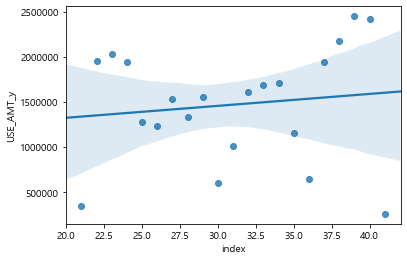

In [157]:
sns.regplot(x='index',y='USE_AMT_y',data=card_temp2, fit_reg=True)

C:\Users\tkdal\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tkdal\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


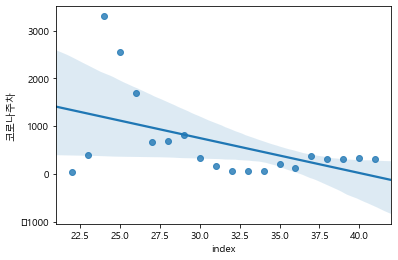

In [162]:
sns.regplot(x='index',y='코로나주차',data=card_temp2, fit_reg=True)

In [249]:
card_temp2['distance'] = card_temp2['USE_AMT_x']/card_temp2['코로나차이']

In [265]:
{"고산1동":card_temp2['distance'].sum()}

{'고산1동': 51581.68519291094}

In [289]:
card_gu_dong_distance

,구명,행정동명,card_gu_dong_distance
0,서울 중구,소공동,55803.616579
1,서울 중구,회현동,77698.917464
2,서울 중구,명동,9146.973300
3,서울 중구,필동,46092.527832
4,서울 중구,장충동,23981.252091
...,...,...,...
64,대구 중구,남산2동,39287.764375
65,대구 중구,남산3동,126187.319727
66,대구 중구,남산4동,4433.772193
67,대구 중구,대봉1동,61630.557856


## 이제 유동인구 데이터를 해보자

In [290]:
flow202002 = pd.read_csv("4개지역_FLOW_AGE_202002.csv", sep ="|")
flow202003 = pd.read_csv("4개지역_FLOW_AGE_202003.csv", sep ="|")
flow202004 = pd.read_csv("4개지역_FLOW_AGE_202004.csv", sep ="|")
flow202005 = pd.read_csv("4개지역_FLOW_AGE_202005.csv", sep ="|")

### 2020년만 갖고와서 합침

In [291]:
flow2020 = pd.concat([flow202002, flow202003, flow202004, flow202005])

In [292]:
flow2020

,STD_YM,STD_YMD,HDONG_CD,HDONG_NM,MAN_FLOW_POP_CNT_0004,MAN_FLOW_POP_CNT_0509,MAN_FLOW_POP_CNT_1014,MAN_FLOW_POP_CNT_1519,MAN_FLOW_POP_CNT_2024,MAN_FLOW_POP_CNT_2529,...,WMAN_FLOW_POP_CNT_2529,WMAN_FLOW_POP_CNT_3034,WMAN_FLOW_POP_CNT_3539,WMAN_FLOW_POP_CNT_4044,WMAN_FLOW_POP_CNT_4549,WMAN_FLOW_POP_CNT_5054,WMAN_FLOW_POP_CNT_5559,WMAN_FLOW_POP_CNT_6064,WMAN_FLOW_POP_CNT_6569,WMAN_FLOW_POP_CNT_70U
0,202002,20200201,1114052000,소공동,0.0,88.95,376.68,1077.03,3602.41,6660.39,...,6961.02,5115.24,4164.47,3927.93,4058.47,3932.39,3650.70,3361.05,2440.61,2665.43
1,202002,20200202,1114052000,소공동,0.0,51.03,271.96,871.27,2824.97,5031.63,...,4702.91,3698.04,2922.33,2781.63,2947.01,2632.34,2669.56,2399.90,1704.22,2026.77
2,202002,20200203,1114052000,소공동,0.0,32.47,136.94,826.26,3580.23,8823.11,...,11109.59,10754.75,9655.01,9018.58,8786.59,7257.35,5710.55,4935.00,3070.67,3349.99
3,202002,20200204,1114052000,소공동,0.0,27.34,154.75,823.69,3510.75,9361.85,...,11771.06,11467.86,9834.22,9323.74,8982.67,7448.09,5938.57,4948.10,3091.30,3494.91
4,202002,20200205,1114052000,소공동,0.0,26.30,177.28,809.21,3579.35,9631.85,...,11876.40,11285.83,9972.17,9299.52,8976.55,7183.79,5719.89,4822.39,2960.73,3204.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,202005,20200527,2726069000,고산3동,0.0,70.07,519.05,956.45,1205.44,1507.57,...,1201.14,1106.57,1728.34,2209.31,2808.54,2721.54,2070.62,1613.50,1086.34,1143.37
2135,202005,20200528,2726069000,고산3동,0.0,99.04,749.36,1085.68,1639.82,1777.32,...,1377.94,1258.02,1847.61,2677.19,3342.68,3036.71,2389.70,1848.92,1291.19,1515.36
2136,202005,20200529,2726069000,고산3동,0.0,155.70,781.70,1235.94,1706.97,1982.74,...,1583.58,1487.06,2149.30,2916.87,3643.31,3395.24,2800.02,2043.25,1356.15,1455.89
2137,202005,20200530,2726069000,고산3동,0.0,119.89,903.85,1236.60,1722.01,2142.41,...,1644.73,1420.31,1812.27,2640.71,3362.25,2909.34,2353.82,1812.56,1242.56,1372.38


In [298]:
flow2020.rename(columns = {"STD_YMD":"STD_DD"}, inplace=True)

In [301]:
flow = flow2020.merge(date_table, how='left',on='STD_DD')

In [302]:
flow.head()

,STD_YM,STD_DD,HDONG_CD,HDONG_NM,MAN_FLOW_POP_CNT_0004,MAN_FLOW_POP_CNT_0509,MAN_FLOW_POP_CNT_1014,MAN_FLOW_POP_CNT_1519,MAN_FLOW_POP_CNT_2024,MAN_FLOW_POP_CNT_2529,...,WMAN_FLOW_POP_CNT_5559,WMAN_FLOW_POP_CNT_6064,WMAN_FLOW_POP_CNT_6569,WMAN_FLOW_POP_CNT_70U,year,month,day,week_num,day_of_week,day_of_week_kr
0,202002,20200201,1114052000,소공동,0.0,88.95,376.68,1077.03,3602.41,6660.39,...,3650.70,3361.05,2440.61,2665.43,2020,2,1,4,5,토
1,202002,20200202,1114052000,소공동,0.0,51.03,271.96,871.27,2824.97,5031.63,...,2669.56,2399.90,1704.22,2026.77,2020,2,2,5,6,일
2,202002,20200203,1114052000,소공동,0.0,32.47,136.94,826.26,3580.23,8823.11,...,5710.55,4935.00,3070.67,3349.99,2020,2,3,5,0,월
3,202002,20200204,1114052000,소공동,0.0,27.34,154.75,823.69,3510.75,9361.85,...,5938.57,4948.10,3091.30,3494.91,2020,2,4,5,1,화
4,202002,20200205,1114052000,소공동,0.0,26.30,177.28,809.21,3579.35,9631.85,...,5719.89,4822.39,2960.73,3204.18,2020,2,5,5,2,수


In [309]:
flow_columns = ['MAN_FLOW_POP_CNT_0004',
       'MAN_FLOW_POP_CNT_0509', 'MAN_FLOW_POP_CNT_1014',
       'MAN_FLOW_POP_CNT_1519', 'MAN_FLOW_POP_CNT_2024',
       'MAN_FLOW_POP_CNT_2529', 'MAN_FLOW_POP_CNT_3034',
       'MAN_FLOW_POP_CNT_3539', 'MAN_FLOW_POP_CNT_4044',
       'MAN_FLOW_POP_CNT_4549', 'MAN_FLOW_POP_CNT_5054',
       'MAN_FLOW_POP_CNT_5559', 'MAN_FLOW_POP_CNT_6064',
       'MAN_FLOW_POP_CNT_6569', 'MAN_FLOW_POP_CNT_70U',
       'WMAN_FLOW_POP_CNT_0004', 'WMAN_FLOW_POP_CNT_0509',
       'WMAN_FLOW_POP_CNT_1014', 'WMAN_FLOW_POP_CNT_1519',
       'WMAN_FLOW_POP_CNT_2024', 'WMAN_FLOW_POP_CNT_2529',
       'WMAN_FLOW_POP_CNT_3034', 'WMAN_FLOW_POP_CNT_3539',
       'WMAN_FLOW_POP_CNT_4044', 'WMAN_FLOW_POP_CNT_4549',
       'WMAN_FLOW_POP_CNT_5054', 'WMAN_FLOW_POP_CNT_5559',
       'WMAN_FLOW_POP_CNT_6064', 'WMAN_FLOW_POP_CNT_6569',
       'WMAN_FLOW_POP_CNT_70U']

In [310]:
flow['flow_sum'] = flow[flow_columns].sum(axis=1)

In [311]:
flow.head()

,STD_YM,STD_DD,HDONG_CD,HDONG_NM,MAN_FLOW_POP_CNT_0004,MAN_FLOW_POP_CNT_0509,MAN_FLOW_POP_CNT_1014,MAN_FLOW_POP_CNT_1519,MAN_FLOW_POP_CNT_2024,MAN_FLOW_POP_CNT_2529,...,WMAN_FLOW_POP_CNT_6064,WMAN_FLOW_POP_CNT_6569,WMAN_FLOW_POP_CNT_70U,year,month,day,week_num,day_of_week,day_of_week_kr,flow_sum
0,202002,20200201,1114052000,소공동,0.0,88.95,376.68,1077.03,3602.41,6660.39,...,3361.05,2440.61,2665.43,2020,2,1,4,5,토,111317.69
1,202002,20200202,1114052000,소공동,0.0,51.03,271.96,871.27,2824.97,5031.63,...,2399.90,1704.22,2026.77,2020,2,2,5,6,일,78918.43
2,202002,20200203,1114052000,소공동,0.0,32.47,136.94,826.26,3580.23,8823.11,...,4935.00,3070.67,3349.99,2020,2,3,5,0,월,201506.87
3,202002,20200204,1114052000,소공동,0.0,27.34,154.75,823.69,3510.75,9361.85,...,4948.10,3091.30,3494.91,2020,2,4,5,1,화,207998.46
4,202002,20200205,1114052000,소공동,0.0,26.30,177.28,809.21,3579.35,9631.85,...,4822.39,2960.73,3204.18,2020,2,5,5,2,수,207158.65


In [312]:
flow_sum = flow.pivot_table(index=['HDONG_NM','year','month','week_num'], values=['flow_sum'], aggfunc='sum')

In [313]:
flow_sum

flow_sum
HDONG_NM year month week_num            
고산1동     2020 2     4          132881.50
                    5          894554.43
                    6          912104.72
                    7          798018.75
                    8          654318.88
...                                  ...
회현동      2020 5     18        1363686.38
                    19        1412572.97
                    20        1413669.98
                    21        1473629.37
                    22         104740.08

[1449 rows x 1 columns]

## 코로나에 대한 유동인구 변화량 민감도

In [332]:
flow_dong_list = flow['HDONG_NM'].unique()

flow_distance = []
for idx, line in enumerate(flow_dong_list):
    
    flow_temp = flow_sum.reset_index()
    flow_daegu_suseonggu_gosan1 = flow_temp[flow_temp['HDONG_NM'] == line]
    flow_daegu_suseonggu_gosan1_2020 = flow_daegu_suseonggu_gosan1[flow_daegu_suseonggu_gosan1['year'] == 2020]
    flow_daegu_suseonggu_gosan1_2020_diff = flow_daegu_suseonggu_gosan1_2020['flow_sum'].diff()
    flow_temp = flow_daegu_suseonggu_gosan1_2020[ ['HDONG_NM'] ]
    flow_temp = flow_temp.reset_index()
    temp = pd.DataFrame(flow_daegu_suseonggu_gosan1_2020_diff)
    temp = temp.reset_index()
    flow_temp2 = flow_temp.merge(temp, how='left', on='index')
    
    temp = pd.DataFrame(flow_daegu_suseonggu_gosan1_2020_diff)
    temp = temp.reset_index()
    flow_temp2 = flow_temp.merge(temp, how='left', on='index')
    
    flow_temp2['코로나누적'] = corona
    flow_temp2['코로나주차'] = flow_temp2['코로나누적'].diff()
    flow_temp2['코로나차이'] = flow_temp2['코로나주차'].diff()
    
    flow_temp2["flow_sum_diff"] = temp['flow_sum']
    flow0 = pd.DataFrame(flow_daegu_suseonggu_gosan1_2020['flow_sum']).reset_index()
    flow_temp2 = flow_temp2.merge(temp0, how='left', on='index')
#    flow_temp2.drop("AMT",axis=1,inplace=True)
    
    flow_temp2['distance'] = flow_temp2['flow_sum_diff']/flow_temp2['코로나차이']
    
    flow_distance.append(flow_temp2['distance'].sum())

In [333]:
flow_temp2

,index,HDONG_NM,flow_sum,코로나누적,코로나주차,코로나차이,flow_sum_diff,USE_AMT,distance
0,42,고산3동,NaN,0,NaN,NaN,NaN,NaN,NaN
1,43,고산3동,303134.88,29,29.0,NaN,303134.88,NaN,NaN
2,44,고산3동,19582.46,433,404.0,375.0,19582.46,NaN,52.219893
3,45,고산3동,-44585.67,3736,3303.0,2899.0,-44585.67,NaN,-15.379672
4,46,고산3동,-42971.33,6284,2548.0,-755.0,-42971.33,NaN,56.915669
5,47,고산3동,10769.87,7979,1695.0,-853.0,10769.87,NaN,-12.625873
6,48,고산3동,7983.42,8652,673.0,-1022.0,7983.42,NaN,-7.811566
7,49,고산3동,2643.75,9332,680.0,7.0,2643.75,NaN,377.678571
8,50,고산3동,587.10,10156,824.0,144.0,587.10,NaN,4.077083
9,51,고산3동,-173388.57,10480,324.0,-500.0,-173388.57,NaN,346.777140


In [334]:
flow_distance

[41027.953814255234,
 55799.84724591997,
 50257.942819760465,
 29559.70666449805,
 26926.567103066736,
 37539.97496230537,
 28199.998816123814,
 26856.138319581518,
 7724.6255630298,
 5570.247172787298,
 7450.423749781163,
 12934.810039659002,
 -3715.562450634434,
 18900.097660702188,
 10563.242360283075,
 25635.791940112424,
 18697.247453102147,
 47265.247176984616,
 74617.41896261061,
 86556.45589633952,
 26771.991248642353,
 29199.754377986297,
 17242.065366366456,
 18185.76232857158,
 17193.105923065723,
 34860.511400077245,
 52563.10795631848,
 33481.62401144665,
 32299.15777270278,
 21657.83324446709,
 98077.97023999978,
 29020.130625384918,
 10378.440579408245,
 16388.047794456354,
 16657.28930062071,
 12204.182112793002,
 20724.47628282215,
 15446.307289943587,
 7565.891015624367,
 7332.915132392081,
 4243.64051168745,
 4845.629663281148,
 3654.1173165771875,
 12835.550967599083,
 46660.475292582865,
 2400.439804796506,
 13795.689453848026,
 13997.54367697102,
 15764.6741633338

In [337]:
card_gu_dong_distance['flow_distance'] = flow_distance

In [341]:
card_flow_corona_distance = card_gu_dong_distance.rename(columns={"card_gu_dong_distance" : "card_distance"})

# 카드소비변화량, 유동인구변화량 합침

In [342]:
card_flow_corona_distance

,구명,행정동명,card_distance,flow_distance
0,서울 중구,소공동,55803.616579,41027.953814
1,서울 중구,회현동,77698.917464,55799.847246
2,서울 중구,명동,9146.973300,50257.942820
3,서울 중구,필동,46092.527832,29559.706664
4,서울 중구,장충동,23981.252091,26926.567103
...,...,...,...,...
64,대구 중구,남산2동,39287.764375,11502.293962
65,대구 중구,남산3동,126187.319727,9813.697449
66,대구 중구,남산4동,4433.772193,72169.877381
67,대구 중구,대봉1동,61630.557856,93715.662757


#### 평균을 따로 구함

In [354]:
card_distance_mean = card_flow_corona_distance.mean()[0]
flow_distance_mean = card_flow_corona_distance.mean()[1]

## 유동인구 민감도(x좌표), 카드소비 민감도(y좌표) 산점도 그래프

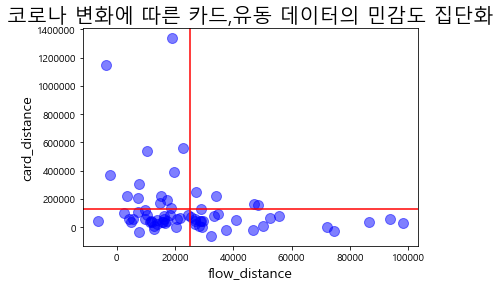

In [351]:
plt.plot('flow_distance',  # x

         'card_distance',  # y

         data=card_flow_corona_distance, 

         linestyle='none', 

         marker='o', 

         markersize=10,

         color='blue', 

         alpha=0.5)

plt.title('코로나 변화에 따른 카드,유동 데이터의 민감도 집단화', fontsize=20)

plt.xlabel('flow_distance', fontsize=14)

plt.ylabel('card_distance', fontsize=14)


plt.axvline(x=flow_distance_mean, color='red')
plt.axhline(y=card_distance_mean, color='red')

plt.show()

- 뉴노멀 시대니까 코로나가 계속 진행되는 상황속에서, 얼마나 코로나에 민감하게 반응하는지 변화를 알아봐야 한다 생각했음
- 이 변화를 어떤 식으로 알아볼지 생각하다가 주차별 변화량으로 잡았고, 객관적인 수학공식이 어떤 건지 알아봤음
- 그래프 유사도 알아보는 공식이 있다고 보아서 그래프 유사도를 코로나 변화량과 카드,유동 데이터의 변화량의 차이를 비교함
- x,y좌표로 잡아서 동부터 집단화해봄
- 만약에 이 지표가 괜찮다 싶으면 산업별로도 해보고, 물류도 포함할 예정입니다!